In [1]:
import pyblp
import numpy as np
import pandas as pd 

# import os module
import os
import matplotlib.pyplot as plt

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'1.1.0'

In [2]:
product_data = pd.read_csv("products_pizza.csv")
agent_data = pd.read_csv("agents_pizza.csv")
product_data.columns=['product_ids', 'market_ids', 'firm_ids', 'shares', 'demand_instruments0',
       'demand_instruments1', 'demand_instruments2', 'demand_instruments3',
       'demand_instruments4', 'supply_instruments0', 'supply_instruments1',
       'supply_instruments2', 'supply_instruments3', 'supply_instruments4',
       'prices', 'deliverytime', 'rating', 'hourlywages', 'ratingmin']


In [3]:
agent_formulation = pyblp.Formulation('0+ invincome')
agent_formulation
product_formulations = (
   pyblp.Formulation('0 + prices'),
   pyblp.Formulation('1 + prices + deliverytime + rating'),
   pyblp.Formulation('1 + rating +hourlywages')
)
product_formulations
problem = pyblp.Problem(product_formulations, product_data, agent_formulation, agent_data)
problem

Dimensions:
 T    N    F    I     K1    K2    K3    D    MD    MS 
---  ---  ---  ----  ----  ----  ----  ---  ----  ----
20   500   6   1620   1     4     3     1    5     8  

Formulations:
        Column Indices:              0        1          2          3   
-------------------------------  ---------  ------  ------------  ------
  X1: Linear Characteristics      prices                                
 X2: Nonlinear Characteristics       1      prices  deliverytime  rating
X3: Linear Cost Characteristics      1      rating  hourlywages         
        d: Demographics          invincome                              

In [4]:
nevo_problem = pyblp.Problem(
    product_formulations,
    product_data,
    agent_formulation,
    agent_data
)
nevo_problem

Dimensions:
 T    N    F    I     K1    K2    K3    D    MD    MS 
---  ---  ---  ----  ----  ----  ----  ---  ----  ----
20   500   6   1620   1     4     3     1    5     8  

Formulations:
        Column Indices:              0        1          2          3   
-------------------------------  ---------  ------  ------------  ------
  X1: Linear Characteristics      prices                                
 X2: Nonlinear Characteristics       1      prices  deliverytime  rating
X3: Linear Cost Characteristics      1      rating  hourlywages         
        d: Demographics          invincome                              

In [30]:
initial_sigma = np.diag([3.612, 0, 0, 1.818])
initial_pi = np.array([ 5.4819,  1,0.2037,  0])
initial_beta=np.c_[[0]]
initial_gamma=np.c_[[3, 1, 0.5]]
tighter_bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-5})
nevo_results = nevo_problem.solve(
    initial_sigma,
    initial_pi,
    beta=initial_beta,
    gamma=initial_gamma,
    optimization=tighter_bfgs,
    method='2s'
)

In [31]:
nevo_results 

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +3.1E+00   +2.6E-06     +1.7E-01        +5.6E+05        0         +1.8E+06          +1.7E+06     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:01:38       No           82           205        383411       1154906  

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
   Sigma:         1        prices   deliverytime    rating    |      Pi:       invincome 
------------  ----------  --------  ------------  ----------  |  ------------  

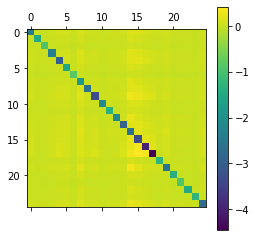

In [32]:
elasticities = nevo_results.compute_elasticities()
diversions = nevo_results.compute_diversion_ratios()
single_market = product_data['market_ids'] ==0
plt.colorbar(plt.matshow(elasticities[single_market]));

In [33]:
np.diagonal(elasticities[single_market])

array([-2.44684205, -1.46242987, -0.91409236, -2.33926347, -2.95325851,
       -1.50067906, -0.8249242 , -1.85592276, -2.63943762, -3.32057708,
       -2.11385982, -1.34128544, -2.13570835, -2.92700815, -2.61794282,
       -3.34127976, -3.96933847, -4.45523004, -1.23794025, -2.55242766,
       -1.36523864, -0.90239787, -1.46516951, -1.26117431, -2.7078307 ])

In [34]:
mean_elasticities = np.mean(elasticities)
mean_elasticities 
means = nevo_results.extract_diagonal_means(elasticities)
means

array([[ -2.18605035],
       [ -0.93063492],
       [ -1.78784557],
       [ -2.28157992],
       [ -2.54175553],
       [ -3.96963486],
       [ -1.47873009],
       [  0.08396121],
       [ -3.87708947],
       [ -0.89880289],
       [ -1.88939557],
       [ -4.88956028],
       [-12.72065174],
       [ -4.51208863],
       [ -1.75286712],
       [ -5.26797367],
       [ -1.8309679 ],
       [ -5.1799186 ],
       [ -4.14863145],
       [ -4.49897882]])

In [35]:
aggregates = nevo_results.compute_aggregate_elasticities(factor=0.1)
aggregates

array([[-0.13937217],
       [-0.18020088],
       [-0.11107163],
       [-0.23992494],
       [-0.22854012],
       [-0.27870771],
       [-0.17181503],
       [-0.03452284],
       [-0.20000475],
       [-0.04363184],
       [-0.14355923],
       [-0.30210132],
       [-0.96467742],
       [-0.25996131],
       [-0.03156282],
       [-0.39641623],
       [-0.12520923],
       [-0.51665283],
       [-0.32911748],
       [-0.270619  ]])

In [36]:
means = nevo_results.extract_diagonal_means(diversions)
means

array([[2.32215440e-01],
       [2.69033365e-01],
       [3.24505973e-01],
       [3.68139124e-01],
       [1.24975245e-01],
       [1.81596736e-01],
       [1.61328616e-01],
       [3.52882126e-01],
       [1.79393481e-01],
       [2.27458796e-04],
       [4.62577182e-01],
       [1.33849691e-01],
       [1.68595592e-01],
       [2.67709182e-01],
       [1.08166943e-01],
       [2.65290479e-01],
       [4.82013069e-01],
       [3.93369072e-01],
       [4.39184617e-01],
       [1.66767182e-01]])

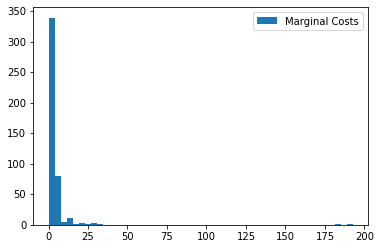

In [37]:
costs = nevo_results.compute_costs()
filtered_costs = costs[costs >= 0]
plt.hist(filtered_costs, bins=50);
plt.legend(["Marginal Costs"]);

In [38]:

# Calculate summary statistics
mean_cost = np.mean(filtered_costs)
median_cost = np.median(filtered_costs)
std_deviation = np.std(filtered_costs)

# Print summary statistics
print("Summary Statistics:")
print(f"Mean Cost: {mean_cost}")
print(f"Median Cost: {median_cost}")
print(f"Standard Deviation: {std_deviation}")

Summary Statistics:
Mean Cost: 4.381415221399167
Median Cost: 2.7192669391556823
Standard Deviation: 12.910993479949589


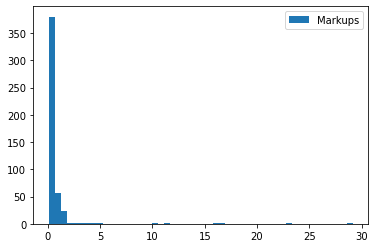

In [39]:
markups =nevo_results.compute_markups(costs=costs)
filtered_markups = markups[markups >= 0]
plt.hist(filtered_markups, bins=50);
plt.legend(["Markups"]);

In [40]:
# Calculate summary statistics
mean_markup = np.mean(filtered_markups)
median_markup = np.median(filtered_markups)
std_deviation_markup = np.std(filtered_markups)

# Print summary statistics
print("Summary Statistics for Filtered Markups:")
print(f"Mean Markup: {mean_markup}")
print(f"Median Markup: {median_markup}")
print(f"Standard Deviation of Markup: {std_deviation_markup}")

Summary Statistics for Filtered Markups:
Mean Markup: 0.7381316335083109
Median Markup: 0.3802605318036348
Standard Deviation of Markup: 2.135516182478023


In [41]:
results=nevo_results
hhi = results.compute_hhi()

In [42]:
mean_HHI = np.mean(hhi)
median_HHI = np.median(hhi)
std_deviation_HHI = np.std(hhi)

# Print summary statistics

print(f"Mean HHI: {mean_HHI}")
print(f"Median HHI: {median_HHI}")
print(f"Standard Deviation of HHI: {std_deviation_HHI}")

Mean HHI: 1868.0849541349949
Median HHI: 1812.8573540025077
Standard Deviation of HHI: 220.04113228644906


In [43]:
profits = results.compute_profits(costs=costs)*6000000
# Calculate summary statistics
mean_profit = np.mean(profits)
median_profit = np.median(profits)
std_deviation_profit = np.std(profits)

# Print summary statistics
print("Summary Statistics for Profits:")
print(f"Mean Profit: {mean_profit}")
print(f"Median Profit: {median_profit}")
print(f"Standard Deviation of Profit: {std_deviation_profit}")

Summary Statistics for Profits:
Mean Profit: 68736.97575604689
Median Profit: 68490.6787176042
Standard Deviation of Profit: 907612.3629187512


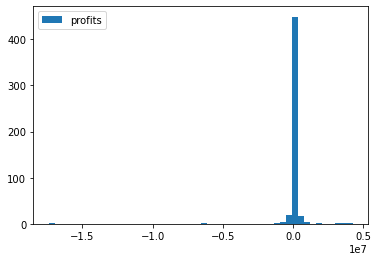

In [44]:
plt.hist(profits, bins=50);
plt.legend(["profits"]);

In [45]:
cs = results.compute_consumer_surpluses()*6000000

In [46]:
df = pd.concat([product_data['market_ids'],pd.DataFrame(cs)],axis=1, ignore_index=True)
df.columns =['market', 'cs']
avgmarkup=pd.DataFrame(df.groupby('market')['cs'].mean())
avgmarkup=np.array(avgmarkup)
avgmarkup[0]

array([8958098.95710743])

In [47]:
product_data['merger_ids'] = product_data['firm_ids'].replace(0,1)
product_data['merger_ids'] = product_data['firm_ids'].replace(2,1)
product_data['merger_ids'] = product_data['firm_ids'].replace(3,1)

In [48]:
changed_prices = results.compute_prices(
    firm_ids=product_data['merger_ids'], 
    costs=costs
)

In [49]:
changed_shares = results.compute_shares(changed_prices)

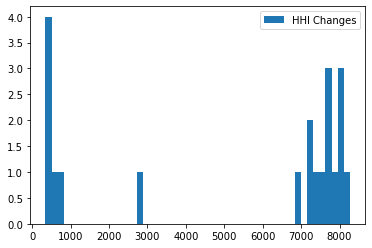

In [50]:
changed_hhi = results.compute_hhi(
    firm_ids=product_data['merger_ids'],
    shares=changed_shares
)
plt.hist(changed_hhi - hhi, bins=50);
plt.legend(["HHI Changes"]);

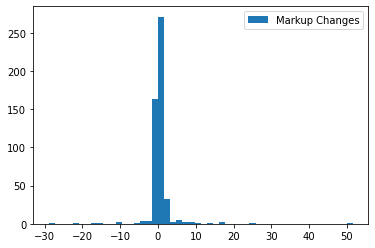

In [51]:
changed_markups = results.compute_markups(changed_prices, costs)
plt.hist(changed_markups - markups, bins=50);
plt.legend(["Markup Changes"]);

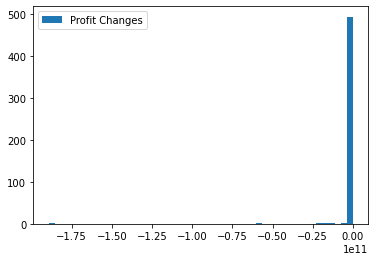

In [52]:
changed_profits = results.compute_profits(changed_prices, changed_shares, costs)*6000000
plt.hist(changed_profits - profits, bins=50);
plt.legend(["Profit Changes"]);

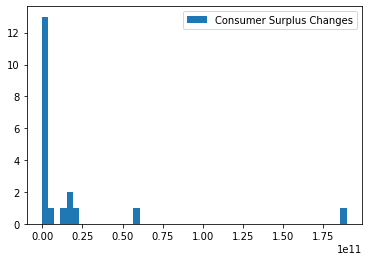

In [53]:
changed_cs = results.compute_consumer_surpluses(changed_prices)*6000000
plt.hist(changed_cs - cs, bins=50);
plt.legend(["Consumer Surplus Changes"]);

In [54]:
mean_markups  = np.mean(changed_markups - markups)
mean_profit = np.mean(changed_profits - profits)
mean_cs = np.mean(changed_cs - cs)
print(f"mean_markupschange: {mean_markups}")
print(f"mean_profitchange: {mean_profit}")
print(f"mean_cschange: {mean_cs}")

mean_markupschange: 0.6939578545086488
mean_profitchange: -659135964.2561997
mean_cschange: 16494358764.502598
